# Self-RAG
---

### What is Self-RAG?

Self-RAG reflects on the retrieved documents and generated responses, and includes a self-evaluation process to improve the quality of the generated answers.

Original paper says Self-RAG generates special tokens, termed "reflection tokens," to determine if retrieval would enhance the response, allowing for on-demand retrieval integration. 
But in practice, we can ignore reflection tokens and let LLM decides if each document is relevant or not.

Corrective RAG (CRAG) is similar to Self-RAG, but Self-RAG focuses on self-reflection and self-evaluation, while CRAG focuses on refining the entire retrieval process including web search.

- Self-RAG: Trains the LLM to be self-sufficient in managing retrieval and generation processes. By generating reflection tokens, the model controls its behavior during inference, deciding when to retrieve information and how to critique and improve its own responses, leading to more accurate and contextually appropriate outputs. 
- CRAG: Focuses on refining the retrieval process by evaluating and correcting the retrieved documents before they are used in generation. It integrates additional retrievals, such as web searches, when initial retrievals are insufficient, ensuring that the generation is based on the most relevant and accurate information available.

**Reference**

- [Self-RAG paper](https://arxiv.org/abs/2310.11511)  

In [1]:
from dotenv import load_dotenv
import os
import json
from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizableTextQuery
from azure.ai.evaluation import (
    GroundednessEvaluator,
    RelevanceEvaluator,
    RetrievalEvaluator,
)
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from autogen_core.models import (
    ChatCompletionClient,
    SystemMessage,
    UserMessage,
    AssistantMessage,
)
from autogen_core import (
    MessageContext,
    RoutedAgent,
    SingleThreadedAgentRuntime,
    TopicId,
    message_handler,
    type_subscription,
)
from pydantic import BaseModel
from typing import List
from dataclasses import dataclass


load_dotenv("../../../.env")

True

In [2]:
# Get the environment variables
azure_ai_search_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
search_credential = (
    AzureKeyCredential(os.getenv("AZURE_SEARCH_ADMIN_KEY", ""))
    if len(os.getenv("AZURE_SEARCH_ADMIN_KEY", "")) > 0
    else DefaultAzureCredential()
)
index_name = os.getenv("AZURE_SEARCH_INDEX_NAME", "hotels-sample-index")

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = (
    os.getenv("AZURE_OPENAI_API_KEY", "")
    if len(os.getenv("AZURE_OPENAI_API_KEY", "")) > 0
    else None
)
azure_openai_chat_deployment_name = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
azure_openai_embedding_deployment_name = os.getenv(
    "AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME", "text-embedding-ada-002"
)
openai_api_version = os.getenv("OPENAI_API_VERSION", "2024-06-01")

model_config = {
    "azure_endpoint": azure_openai_endpoint,
    "api_key": azure_openai_key,
    "azure_deployment": azure_openai_chat_deployment_name,
    "api_version": openai_api_version,
    "type": "azure_openai",
}

## 🧪 Step 1. Test and Construct each module
---

Before building the entire the graph pipeline, we will test and construct each module separately.

- **Retrieval Grader**
- **Answer Generator**
- **Groundedness Evaluator**
- **Relevance Evaluator**
- **Question Re-writer**

### Construct Retrieval Chain based on PDF
- We use the hotels-sample-index, which can be created in minutes and runs on any search service tier. This index is created by a wizard using built-in sample data.

In [3]:
azure_ai_search_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
azure_search_admin_key = os.getenv("AZURE_SEARCH_ADMIN_KEY", "")
search_client = SearchClient(
    endpoint=azure_ai_search_endpoint,
    index_name=index_name,
    credential=AzureKeyCredential(azure_search_admin_key),
    semantic_configuration_name="my-semantic-config",
)

# Query is the question being asked. It's sent to the search engine and the LLM.
query = "Can you recommend a few hotels with complimentary breakfast?"

fields = "descriptionVector"  # TODO: Check if this is the correct field name
# don't use exhaustive search for large indexes
vector_query = VectorizableTextQuery(
    text=query, k_nearest_neighbors=2, fields=fields, exhaustive=True
)

# Search results are created by the search client.
# Search results are composed of the top 3 results and the fields selected from the search index.
# Search results include the top 3 matches to your query.
search_results = search_client.search(
    search_text=query,
    vector_queries=[vector_query],
    select="Description,HotelName,Tags",
    top=3,
)
sources_formatted = "\n".join(
    [
        f'{document["HotelName"]}:{document["Description"]}:{document["Tags"]}'
        for document in search_results
    ]
)

print(sources_formatted)

Lion's Den Inn:Full breakfast buffet for 2 for only $1. Excited to show off our room upgrades, faster high speed WiFi, updated corridors & meeting space. Come relax and enjoy your stay.:['laundry service', 'free wifi', 'restaurant']
Lakefront Captain Inn:Every stay starts with a warm cookie. Amenities like the Counting Sheep sleep experience, our Wake-up glorious breakfast buffet and spacious workout facilities await.:['restaurant', 'laundry service', 'coffee in lobby']
Starlight Suites:Complimentary Airport Shuttle & WiFi. Book Now and save - Spacious All Suite Hotel, Indoor Outdoor Pool, Fitness Center, Florida Green certified, Complimentary Coffee, HDTV:['pool', 'coffee in lobby', 'free wifi']


### Define your LLM

This hands-on only uses the `gpt-4o-mini`, but you can utilize multiple models in the pipeline.

In [4]:
# aoai_client = AzureOpenAI(
#     azure_endpoint=azure_openai_endpoint,
#     api_key=azure_openai_key,
#     api_version=openai_api_version,
# )

# This is not the same object as the one above. This is the client that is used to interact with the Azure OpenAI Chat API.
autogen_aoai_client = AzureOpenAIChatCompletionClient(
    azure_endpoint=azure_openai_endpoint,
    model=azure_openai_chat_deployment_name,
    api_version=openai_api_version,
    api_key=azure_openai_key,
)

### Question-Retrieval Grader

Construct a retrieval grader that evaluates the relevance of the retrieved documents to the input question. The retrieval grader should take the input question and the retrieved documents as input and output a relevance score for each document.<br>
Note that the retrieval grader should be able to handle **multiple documents** as input.

In [5]:
retrieval_eval = RetrievalEvaluator(model_config)

query_response = dict(query=query, context=sources_formatted)

relevance_score = retrieval_eval(**query_response)
print(relevance_score)
relevance_score["retrieval"]

{'retrieval': 5.0, 'gpt_retrieval': 5.0, 'retrieval_reason': 'The context chunks provide relevant information about hotels that offer complimentary breakfast, with the most relevant chunks appearing at the top of the list. This aligns well with the query, making the retrieval effective.'}


5.0

### Answer Generator

Construct a LLM Generation node. This is a Naive RAG chain that generates an answer based on the retrieved documents. 

We recommend you to use more advanced RAG chain for production

In [6]:
from pydantic import BaseModel
from typing import List


class HotelInfo(BaseModel):
    hotel_name: str
    description: str


class RecommendationList(BaseModel):
    recommendation: List[HotelInfo]

In [7]:
# This prompt provides instructions to the model
GROUNDED_PROMPT = """
You are a friendly assistant that recommends hotels based on activities and amenities.
Answer the query using only the context provided below in a friendly and concise bulleted manner.
Answer ONLY with the facts listed in the list of context below.
If there isn't enough information below, say you don't know.
Generate a response that includes the top 3 results.
Do not generate answers that don't use the context below.
Query: {query}
Context:\n{context}
"""

# Send the search results and the query to the LLM to generate a response based on the prompt.
response = await autogen_aoai_client.create(
    messages=[
        UserMessage(
            content=GROUNDED_PROMPT.format(query=query, context=sources_formatted),
            source="user",
        ),
    ],
    extra_create_args={"response_format": RecommendationList},
)

response_content = json.loads(response.content)
for recommendation in response_content["recommendation"]:
    print(recommendation)

{'hotel_name': "Lion's Den Inn", 'description': 'Full breakfast buffet for 2 for only $1.'}
{'hotel_name': 'Lakefront Captain Inn', 'description': 'Wake-up glorious breakfast buffet and spacious workout facilities await.'}
{'hotel_name': 'Starlight Suites', 'description': 'Complimentary Coffee, but does not specify breakfast.'}


### Groundedness Evaluator

Construct a `groundedness_grader` node to evaluate the **hallucination** of the generated answer based on the retrieved documents.<br>

`yes` means the answer is relevant to the retrieved documents, and `no` means the answer is not relevant to the retrieved documents.

In [8]:
groundedness_eval = GroundednessEvaluator(model_config)

query_response = dict(query=query, context=sources_formatted, response=response_content)

groundedness_score = groundedness_eval(**query_response)
print(groundedness_score)

{'groundedness': 4.0, 'gpt_groundedness': 4.0, 'groundedness_reason': 'The RESPONSE includes two hotels that offer complimentary breakfast but also mentions a third hotel that does not specify breakfast, which detracts from its overall accuracy and completeness in relation to the QUERY. Therefore, it is not fully grounded in the context.'}


### Relevance Evaluator

Construct a `relevance_grader` node to evaluate the relevance of the generated answer to the question.<br>
`yes` means the answer is relevant to the question, and `no` means the answer is not relevant to the question.

In [9]:
relevance_eval = RelevanceEvaluator(model_config)

query_response = dict(query=query, response=response_content)

relevance_score = relevance_eval(**query_response)
print(relevance_score)

{'relevance': 3.0, 'gpt_relevance': 3.0, 'relevance_reason': 'The RESPONSE partially addresses the QUERY by listing hotels with breakfast options, but it fails to provide clear information about breakfast for one of the hotels. This omission makes the response incomplete rather than fully relevant.'}


### Question Re-writer

Construct a `question_rewriter` node to rewrite the question based on the retrieved documents and the generated answer.

In [10]:
query = "Can you recommend a few factories with complimentary breakfast?"

# This prompt provides instructions to the model
REWRITE_PROMPT = """
You a question re-writer that converts an input question to a better version that is optimized
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning.
Query: {query}
"""

# Send the search results and the query to the LLM to generate a response based on the prompt.
response = await autogen_aoai_client.create(
    messages=[
        UserMessage(content=REWRITE_PROMPT.format(query=query), source="user"),
    ]
)


# Here is the response from the chat model.
print(response.content)

Could you suggest some hotels that offer complimentary breakfast?


<br>

## 🧪 Step 2. Define the Agentic Architecture
- Before building the agentic pipeline, we need to design the message, topic, agent and message routing logic. 
- You should define the terminate condition for the pipeline.

### Message, Topic, Agent Definition

```markdown
```python

# Message Definition
@dataclass
class Message:
    query: str = None
    context: str = None
    response: str = None
    source: str = None


# Topic Definition
user_query_topic_type = "UserQueryTopic"
rewrite_topic_type = "RewriteQueryTopic"
generate_topic_type = "GenerateTopic"
eval_topic_type = "EvalTopic"

# Agent Definition
class RetrievalGraderAgent(RoutedAgent):
class RewriteQueryAgent(RoutedAgent):
class GenerateAgent(RoutedAgent):
class EvalAgent(RoutedAgent):
class UserAgent(RoutedAgent):

# Message Routing Definition
user_query_topic -> RetrievalGraderAgent -> RewriteQueryAgent -> RetrievalGraderAgent(revisit) -> GenerateAgent -> EvalAgent -> UserAgent
                                         -> GenerateAgent -> EvalAgent -> UserAgent
```
```

Visualizing the abstract architecture of the pipeline will help you understand the message flow and the agent's role in the pipeline.

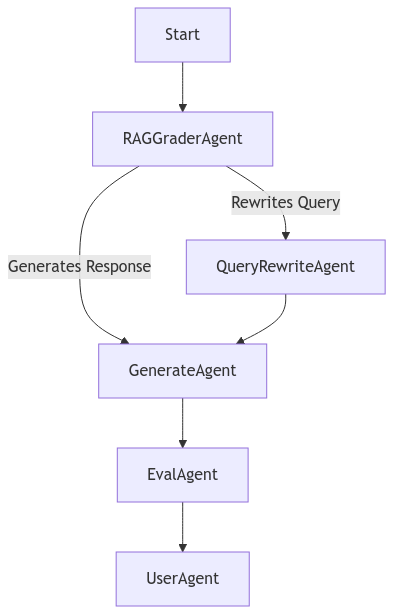

In [11]:
from azure_genai_utils.graphs import visualize_agents

agents = [
    "Start",
    "RAGGraderAgent",
    "QueryRewriteAgent",
    "GenerateAgent",
    "EvalAgent",
    "UserAgent",
]
interactions = [
    ("Start", "RAGGraderAgent"),
    ("RAGGraderAgent", "GenerateAgent", "Generates Response"),
    ("RAGGraderAgent", "QueryRewriteAgent", "Rewrites Query"),
    ("QueryRewriteAgent", "GenerateAgent"),
    ("GenerateAgent", "EvalAgent"),
    ("EvalAgent", "UserAgent"),
]

visualize_agents(agents, interactions)

In [12]:
@dataclass
class Message:
    query: str = None
    context: str = None
    response: str = None
    source: str = None

    def set_source(self, source: str) -> "Message":
        self.source = source
        return self


# Topic Definition
user_query_topic_type = "UserQueryTopic"
query_rewrite_topic_type = "QueryRewriteAgent"
generate_topic_type = "GenerateAgent"
eval_topic_type = "EvalAgent"
user_topic_type = "UserAgent"

In [13]:
@type_subscription(topic_type=user_query_topic_type)
class RAGGraderAgent(RoutedAgent):

    def __init__(
        self,
        azure_ai_search_endpoint: str,
        azure_search_admin_key: str,
        index_name: str,
        retrieval_evaluator: RetrievalEvaluator,
    ) -> None:

        super().__init__("RAG Grader Agent")
        self.index_name = index_name
        self.azure_ai_search_endpoint = azure_ai_search_endpoint
        self.azure_search_admin_key = azure_search_admin_key
        self.retrieval_evaluator = retrieval_evaluator

    def config_search(self) -> SearchClient:
        service_endpoint = self.azure_ai_search_endpoint
        key = self.azure_search_admin_key
        index_name = self.index_name
        credential = AzureKeyCredential(key)
        return SearchClient(
            endpoint=service_endpoint, index_name=index_name, credential=credential
        )

    async def do_search(self, query: str) -> str:
        """Search indexed data using Azure Cognitive Search with vector-based queries."""
        aia_search_client = self.config_search()

        fields = "descriptionVector"  # TODO: Check if this is the correct field name
        # don't use exhaustive search for large indexes
        vector_query = VectorizableTextQuery(
            text=query, k_nearest_neighbors=1, fields=fields, exhaustive=True
        )

        search_results = aia_search_client.search(
            search_text=query,
            vector_queries=[vector_query],
            select=[
                "Description,HotelName,Tags"
            ],  # TODO: Check if these are the correct field names
            top=3,  # TODO: Check if this is the correct number of results
        )
        answer = "\n".join(
            [
                f'{document["HotelName"]}:{document["Description"]}:{document["Tags"]}'
                for document in search_results
            ]
        )
        return answer

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:

        context_from_ai_search = await self.do_search(message.query)
        print(context_from_ai_search)

        query_response = dict(query=query, context=context_from_ai_search)

        retrieval_score = self.retrieval_evaluator(**query_response)

        print(f"retrieval_score: {retrieval_score['retrieval']}")

        if retrieval_score["retrieval"] >= 3.0:
            await self.publish_message(
                Message(
                    query=query, context=context_from_ai_search, source=message.source
                ),
                topic_id=TopicId(type=generate_topic_type, source=message.source),
            )
        else:
            await self.publish_message(
                Message(
                    query=query, context=context_from_ai_search, source=message.source
                ),
                topic_id=TopicId(type=query_rewrite_topic_type, source=message.source),
            )

In [14]:
REWRITE_PROMPT = """
You a question re-writer that converts an input question to a better version that is optimized
for vectorstore retrieval. Look at the input and try to rewrite about the underlying semantic intent / meaning.
Query: {query}
"""


@type_subscription(topic_type=query_rewrite_topic_type)
class QueryRewriteAgent(RoutedAgent):
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("Query Rewrite Agent")
        self._system_message = SystemMessage(
            content=(
                """
                    You are an helper agent that can rewrite the query.
                """
            )
        )
        self._model_client = model_client

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        print(message)
        llm_result = await self._model_client.create(
            messages=[
                self._system_message,
                UserMessage(
                    content=REWRITE_PROMPT.format(query=message.query),
                    source=message.source,
                ),
            ],
            cancellation_token=ctx.cancellation_token,
        )
        response = llm_result.content
        print(response)
        assert isinstance(response, str)
        print(f"{'-'*80}\n{self.id.type}:\n{response}")

        await self.publish_message(
            Message(query=response, context=message.context, source=message.source),
            topic_id=TopicId(type=generate_topic_type, source=message.source),
        )

In [15]:
# This prompt provides instructions to the model
GROUNDED_PROMPT = """
Answer the query using only the context provided below in a friendly and concise bulleted manner.
Answer ONLY with the facts listed in the list of context below.
If there isn't enough information below, say you don't know.
Do not generate answers that don't use the context below.
Query: {query}
Context:\n{context}
"""


@type_subscription(topic_type=generate_topic_type)
class GenerateAgent(RoutedAgent):
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("Generate Agent")
        self._system_message = SystemMessage(
            content=(
                """
                    You are a friendly assistant that recommends hotels based on activities and amenities.
                """
            )
        )
        self._model_client = model_client

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        llm_result = await self._model_client.create(
            messages=[
                self._system_message,
                UserMessage(
                    content=GROUNDED_PROMPT.format(
                        query=message.query, context=message.context
                    ),
                    source=message.source,
                ),
            ],
            extra_create_args={"response_format": RecommendationList},
            cancellation_token=ctx.cancellation_token,
        )
        response = llm_result.content
        assert isinstance(response, str)
        print(f"{'-'*80}\n{self.id.type}:\n{response}")
        await self.publish_message(
            Message(
                query=message.query,
                context=message.context,
                response=response,
                source=message.source,
            ),
            topic_id=TopicId(type=eval_topic_type, source=self.id.key),
        )

In [16]:
INCORRECT_ANSWER = """
Hello, and thank you for bringing this to our attention! I may have provided an inaccurate or misleading response, and I sincerely apologize for the confusion.
As an AI, I aim to deliver helpful and accurate information, but sometimes I might misinterpret or generate an incorrect response. Your feedback is invaluable and helps me improve.

If you'd like, feel free to share more details or clarify your question, and I’ll do my best to assist you further. Thank you for your understanding and patience! 😊
"""


@type_subscription(topic_type=eval_topic_type)
class EvalAgent(RoutedAgent):

    def __init__(
        self,
        groundedness_evaluator: GroundednessEvaluator,
        relevance_evaluator: RelevanceEvaluator,
    ) -> None:

        super().__init__("Eval Agent")
        self.groundedness_evaluator = groundedness_evaluator
        self.relevance_evaluator = relevance_evaluator

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:

        query_response = dict(
            query=message.query, context=message.context, response=message.response
        )

        groundedness_score = self.groundedness_evaluator(**query_response)
        print(f"groundness_score: {groundedness_score['groundedness']}")
        if groundedness_score["groundedness"] < 3.0:
            await self.publish_message(
                AssistantMessage(content=INCORRECT_ANSWER, source=message.source),
                topic_id=TopicId(type=user_topic_type, source=message.source),
            )
        relevance_score = self.relevance_evaluator(**query_response)
        print(f"relevance_score: {relevance_score['relevance']}")
        if relevance_score["relevance"] < 3.0:
            await self.publish_message(
                AssistantMessage(content=INCORRECT_ANSWER, source=message.source),
                topic_id=TopicId(type=user_topic_type, source=message.source),
            )

        await self.publish_message(
            AssistantMessage(content=message.response, source=message.source),
            topic_id=TopicId(type=user_topic_type, source=message.source),
        )

In [17]:
@type_subscription(topic_type=user_topic_type)
class UserAgent(RoutedAgent):
    def __init__(self) -> None:
        super().__init__("A user agent that outputs the final copy to the user.")

    @message_handler
    async def handle_final_copy(
        self, message: AssistantMessage, ctx: MessageContext
    ) -> None:
        print(f"\n{'-'*80}\n{self.id.type} received final copy:\n{message.content}")

<br>

## 🧪 Step 3. Execute the Workflow
---

### Execute the workflow

In [18]:
runtime = SingleThreadedAgentRuntime()

await RAGGraderAgent.register(
    runtime,
    type=user_query_topic_type,
    factory=lambda: RAGGraderAgent(
        azure_ai_search_endpoint=azure_ai_search_endpoint,
        azure_search_admin_key=azure_search_admin_key,
        index_name=index_name,
        retrieval_evaluator=RetrievalEvaluator(model_config),
    ),
)

await QueryRewriteAgent.register(
    runtime,
    type=query_rewrite_topic_type,
    factory=lambda: QueryRewriteAgent(model_client=autogen_aoai_client),
)

await GenerateAgent.register(
    runtime,
    type=generate_topic_type,
    factory=lambda: GenerateAgent(model_client=autogen_aoai_client),
)

await EvalAgent.register(
    runtime,
    type=eval_topic_type,
    factory=lambda: EvalAgent(
        groundedness_evaluator=GroundednessEvaluator(model_config),
        relevance_evaluator=RelevanceEvaluator(model_config),
    ),
)


await UserAgent.register(runtime, type=user_topic_type, factory=lambda: UserAgent())

AgentType(type='UserAgent')

In [19]:
import time

start_time = time.perf_counter()

runtime.start()
await runtime.publish_message(
    Message(
        query="Can you recommend a few factory with complimentary breakfast?",
        source="User",
    ),
    topic_id=TopicId(type=user_query_topic_type, source="user"),
)
await runtime.stop_when_idle()

end_time = time.perf_counter()
print(f"Elapsed time: {end_time - start_time} seconds")

Lakefront Captain Inn:Every stay starts with a warm cookie. Amenities like the Counting Sheep sleep experience, our Wake-up glorious breakfast buffet and spacious workout facilities await.:['restaurant', 'laundry service', 'coffee in lobby']
Good Business Hotel:1 Mile from the airport. Free WiFi, Outdoor Pool, Complimentary Airport Shuttle, 6 miles from Lake Lanier & 10 miles from downtown. Our business center includes printers, a copy machine, fax, and a work area.:['pool', 'continental breakfast', 'free parking']
Starlight Suites:Complimentary Airport Shuttle & WiFi. Book Now and save - Spacious All Suite Hotel, Indoor Outdoor Pool, Fitness Center, Florida Green certified, Complimentary Coffee, HDTV:['pool', 'coffee in lobby', 'free wifi']
retrieval_score: 1.0
Message(query='Can you recommend a few factories with complimentary breakfast?', context="Lakefront Captain Inn:Every stay starts with a warm cookie. Amenities like the Counting Sheep sleep experience, our Wake-up glorious brea